
Imports



In [304]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt
import math

Load the Image




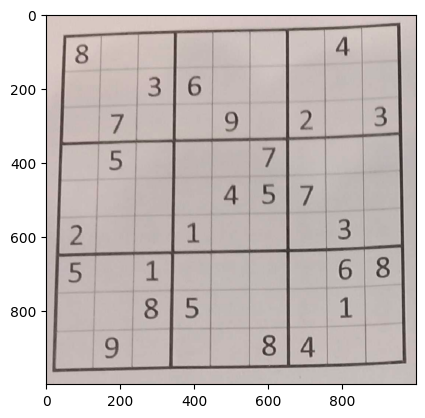

In [305]:
img = cv2.imread('/home/youssef/Projects/Sudoku-Image-Processing/Project Test Cases-20231212/01.jpg')

plt.imshow(img, cmap="gray")


Convert to Grayscale

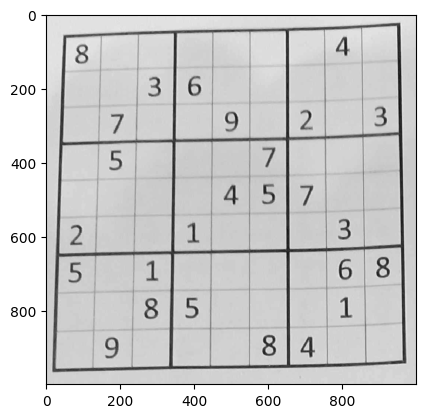

In [306]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_image, cmap="gray")

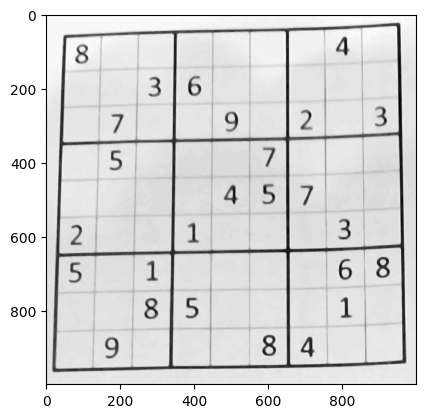

In [307]:
mean1 = cv2.medianBlur(gray_image,5)
mean2 = cv2.medianBlur(mean1,5)
mean3 = cv2.medianBlur(mean2,5)
plt.imshow(mean3, cmap="gray")

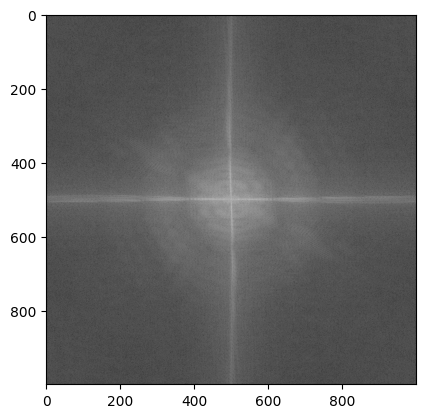

In [308]:
dft_img = np.fft.fft2(mean3)
dft_img_shift = np.fft.fftshift(dft_img)
plt.imshow(np.log(np.abs(dft_img_shift)), cmap = 'gray');

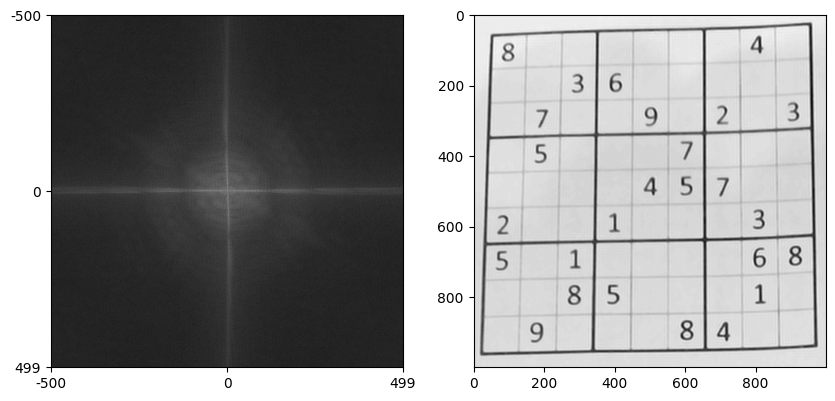

In [309]:
mask = np.zeros(dft_img.shape)
cy = mask.shape[0] // 2
cx = mask.shape[1] // 2
cv2.circle(mask, (cx,cy), 120, (255,255,255), -1).astype(np.uint8)
mask = cv2.GaussianBlur(mask, (21,21), 0)
dft_img_shifted = np.fft.fftshift(dft_img)
dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted_lowpass))
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
ax1.set(yticks=[0, img.shape[0]//2, img.shape[0] - 1], yticklabels=[-img.shape[0]//2, 0, img.shape[0]//2 - 1]);
ax1.set(xticks=[0, img.shape[1]//2, img.shape[1] - 1], xticklabels=[-img.shape[1]//2, 0, img.shape[1]//2 - 1]);
ax1.imshow(np.abs(dft_img_shifted)**0.1, cmap = 'gray');
ax2.imshow(np.abs(img), cmap = 'gray')

In [310]:
img1 = np.fft.ifft2(np.fft.ifftshift(dft_img))
img1 = np.abs(img1)

Adaptive Thresholding

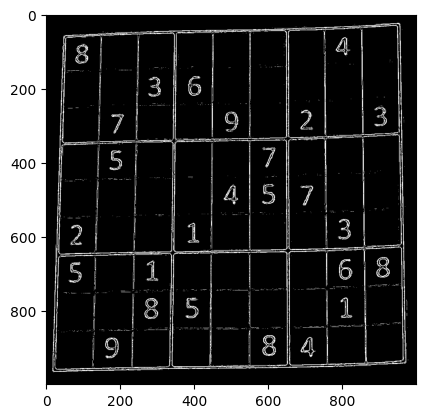

In [311]:

img_gray_threshed = cv2.adaptiveThreshold(src=img1.astype(np.uint8),
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=5,
    C=3
)

plt.imshow(img_gray_threshed, cmap="gray")

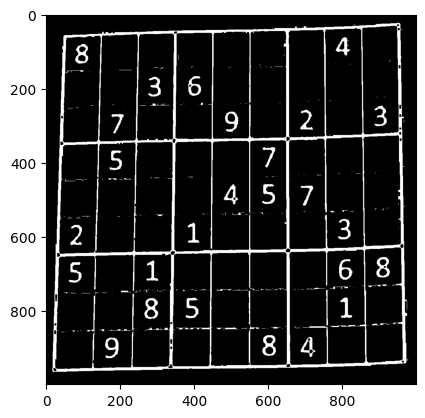

In [312]:
mean4 = cv2.medianBlur(img_gray_threshed,3)
closed_grid = np.zeros_like(mean4, dtype = np.uint8)
closed_grid = cv2.morphologyEx(img_gray_threshed, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
plt.imshow(closed_grid, cmap="gray")

Get the largest object in the image using Cotours

It is assumed that the sudoku frame is the largest object in the image

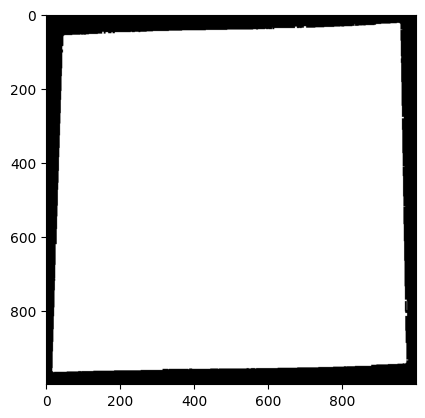

In [313]:
max = -1
x = -1
contours, _ = cv2.findContours(closed_grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
selected_contours = []
sudoku_square = np.zeros(img_gray_threshed.shape, np.uint8)
for i in range(len(contours)):
  area = cv2.contourArea(contours[i])
  if area > max:
     max = area
     x = i

selected_contours.append(contours[x])
cv2.fillPoly(sudoku_square, pts=selected_contours, color= (255,255,255))
plt.imshow(sudoku_square, cmap="gray")

Extract Edges using Canny

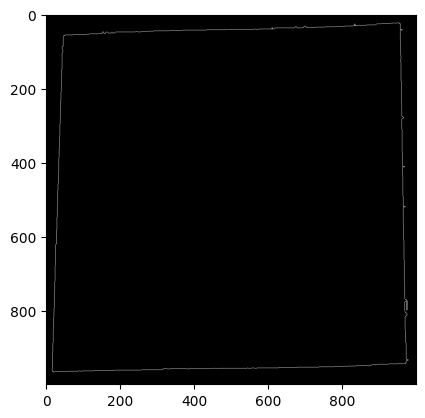

In [314]:
dx = cv2.Sobel(sudoku_square,cv2.CV_16S,1,0,None,5,1,5)
dy = cv2.Sobel(sudoku_square,cv2.CV_16S,0,1,None,5,1,5)
canny_img = cv2.Canny(dx,dy,230,255,None,True)

plt.imshow(canny_img, cmap="gray")

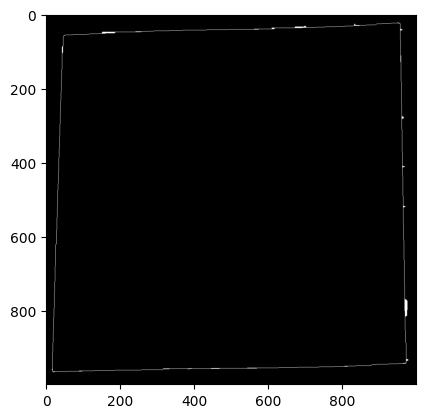

In [315]:
# closed_grid = np.zeros_like(img_gray_threshed, dtype = np.uint8)
# closed_grid = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21)))
# plt.imshow(closed_grid, cmap="gray")

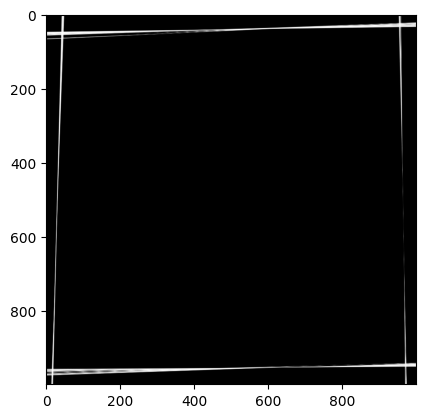

In [316]:

newimg = cv2.Canny(canny_img, 50, 150)

hough_lines = cv2.HoughLines(
    image=newimg,
    rho=1,  # Distance resolution of the accumulator in pixels.
    theta=0.00120,  # Angle resolution of the accumulator in radians.
    threshold=250,  # Voting threshold for accumulator.
    lines=None,
    min_theta=0,  # Minimum angle to check for lines in radians.
    max_theta=math.pi  # Maximum angle to check for lines in radians.
)

tmp_imgy = np.zeros_like(img_gray_threshed, dtype = np.uint8)
for rho, theta in hough_lines[:,0]:
    # Mapping from polar (rho, theta) to cartesian (x0, y0)
    x0 = math.cos(theta) * rho
    y0 = math.sin(theta) * rho
    # Create an extension to the points
    pt1 = (int(x0 + 2000*(-math.sin(theta))), int(y0 + 2000*(math.cos(theta))))
    pt2 = (int(x0 - 2000*(-math.sin(theta))), int(y0 - 2000*(math.cos(theta))))
    cv2.line(tmp_imgy, pt1, pt2, (255,0,0), 1, cv2.LINE_AA)




tmp_imgy = cv2.erode(tmp_imgy,cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)))

plt.imshow(tmp_imgy, cmap='gray')

Get the corners using Harris

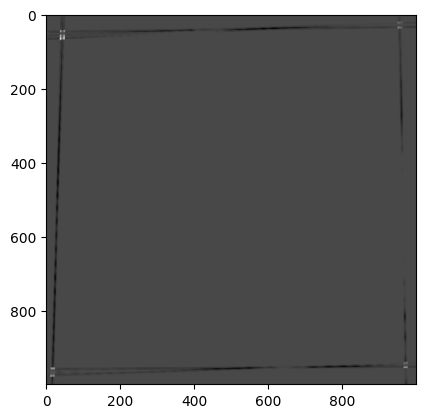

In [317]:
dest = cv2.cornerHarris(tmp_imgy, 7, 3, 0.04)

plt.imshow(dest, cmap="gray")

Apply a Gaussian Filter, get the absolute values, then Threshhold to only get the corner points

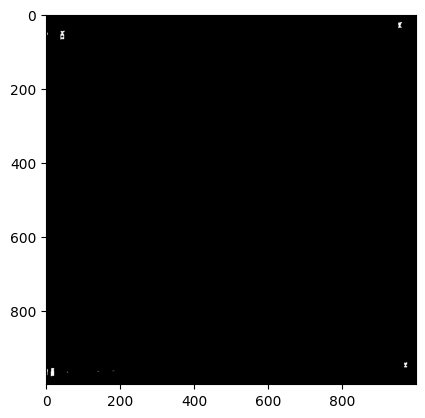

In [318]:
ret, thresh1 = cv2.threshold(dest, 0, 255, cv2.THRESH_BINARY)

dest = thresh1.copy()
dest = cv2.erode(thresh1,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))


plt.imshow(dest, cmap="gray")

Get the coordinates of the Corners

In [319]:
center_point = (dest.shape[0] // 2, dest.shape[1] // 2)

left_part = dest[:, :center_point[1]]

right_part = dest[:, center_point[1]:]


top_left_part = left_part[:center_point[0], :]
bottom_left_part = left_part[center_point[0]:, :]

top_right_part = right_part[:center_point[0], :]
bottom_right_part = right_part[center_point[0]:, :]

c1 = (-1, -1)
found = False
for i in range(len(top_left_part)):
    for j in range(len(top_left_part[0])):
        if top_left_part[i][j] > 0:
            c1 = (i+10, j+10)
            found = True
            break
    if found:
        break

print(c1)

c2 = (-1, -1)
found = False
for i in range(len(top_right_part)):
    for j in range(len(top_right_part[0])):
        if top_right_part[i][j] > 0:
            c2 = (i+10, j + center_point[1]+10)
            found = True
            break
    if found:
        break

print(c2)

c3 = (-1, -1)
found = False
for i in range(len(bottom_left_part)):
    for j in range(len(bottom_left_part[0])):
        if bottom_left_part[i][j] > 0:
            c3 = (i + center_point[0]+10, j+10)
            found = True
            break
    if found:
        break

print(c3)

c4 = (-1, -1)
found = False
for i in range(len(bottom_right_part)):
    for j in range(len(bottom_right_part[0])):
        if bottom_right_part[i][j] > 0:
            c4 = (i + center_point[0]+10, j + center_point[1]+10)
            found = True
            break
    if found:
        break

print(c4)

(10, 54)
(10, 963)
(967, 24)
(951, 984)


Perspective Transform

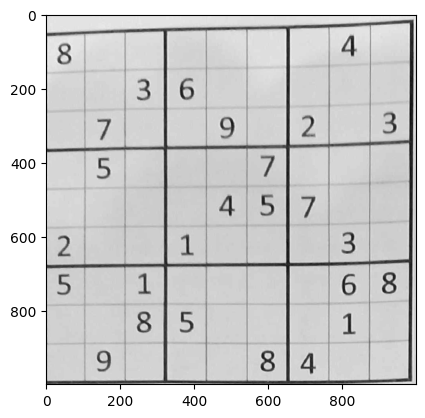

In [320]:
input_points = np.float32([c1[::-1], c2[::-1], c3[::-1], c4[::-1]])
width = img.shape[1]
height = img.shape[0]

converted_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(gray_image, matrix, (width, height))
plt.imshow(img_output, cmap="gray")

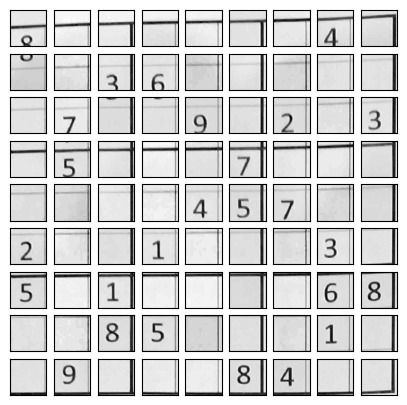

In [321]:
M = img_output.shape[0] // 9
N = img_output.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_output[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)